In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno
from matplotlib.colors import LogNorm


# Pandas Printing Options
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set_style('white')

# DOWNLOAD DATA

In [2]:
ls ..

bower_components/ data/             index.html*       notebooks/
css/              images/           js/


In [3]:
!wget -O - 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD' > ../data/nypd_collision_data.csv

--2017-03-05 21:05:59--  https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD
Resolving data.cityofnewyork.us... 52.206.68.26, 52.206.68.26, 52.206.140.205
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘STDOUT’

-                       [                <=> ] 179.56M   750KB/s    in 1m 53s  

Last-modified header invalid -- time-stamp ignored.
2017-03-05 21:07:52 (1.59 MB/s) - written to stdout [188287277]



# LOAD DATA

In [4]:
data = pd.read_csv("../data/nypd_collision_data.csv", low_memory=False)

In [5]:
# CREATE DATETIME COLUMN
data['DATE'] = pd.to_datetime(data['DATE'] + ' ' + data['TIME'])

# SET DATETIME AS INDEX
data = data.set_index('DATE')

# ADD COLLISION COLUMN FOR SIMPLE AGGREGATION
data['COLLISION'] = 1

# SCOPE OUT HIGHLEVEL DATA INFORMATION
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 987872 entries, 2017-02-09 17:15:00 to 2012-07-01 09:15:00
Data columns (total 29 columns):
TIME                             987872 non-null object
BOROUGH                          728178 non-null object
ZIP CODE                         728078 non-null float64
LATITUDE                         786564 non-null float64
LONGITUDE                        786564 non-null float64
LOCATION                         786564 non-null object
ON STREET NAME                   800677 non-null object
CROSS STREET NAME                771699 non-null object
OFF STREET NAME                  73331 non-null object
NUMBER OF PERSONS INJURED        987872 non-null int64
NUMBER OF PERSONS KILLED         987872 non-null int64
NUMBER OF PEDESTRIANS INJURED    987872 non-null int64
NUMBER OF PEDESTRIANS KILLED     987872 non-null int64
NUMBER OF CYCLIST INJURED        987872 non-null int64
NUMBER OF CYCLIST KILLED         987872 non-null int64
NUMBER OF MOTORIST 

In [6]:
# # NOTE: data starting 2013-01-01 and ending in 2017-02-28
print(data.index.min())
print(data.index.max())

2012-07-01 00:05:00
2017-02-28 23:36:00


# FILTER FOR COLLISIONS WITH PEDESTRIANS INJURED 

In [7]:
data = data[data['NUMBER OF PEDESTRIANS INJURED']!=0]


# SAVE FULL DATA FOR USE LATER
full_data = data['2013/01/01':'2017/02/28']
full_data.to_csv("../data/injuries_2013_2016.csv")

# FILTER DATA FOR THIS NOTEBOOK
data = data['2013/01/01':'2017/02/28']
data.to_csv("../data/injuries_2013_present.csv")

data.shape

(43849, 29)

# NUM PEDESTRIANS INJURED FROM AUTO COLLISIONS

In [8]:
monthly_injured = data.resample('M')['NUMBER OF PEDESTRIANS INJURED'].sum()
monthly_injured[:10]

DATE
2013-01-31    1113
2013-02-28     984
2013-03-31     987
2013-04-30     901
2013-05-31     982
2013-06-30     972
2013-07-31     854
2013-08-31     853
2013-09-30     999
2013-10-31    1066
Freq: M, Name: NUMBER OF PEDESTRIANS INJURED, dtype: int64

In [9]:
daily_injured = data.resample('D')['NUMBER OF PEDESTRIANS INJURED'].sum()
daily_injured[:10]

daily_injured[:10]

DATE
2013-01-01    34
2013-01-02    22
2013-01-03    43
2013-01-04    31
2013-01-05    28
2013-01-06    25
2013-01-07    38
2013-01-08    30
2013-01-09    40
2013-01-10    51
Freq: D, Name: NUMBER OF PEDESTRIANS INJURED, dtype: int64

# FILTER BY BORO

In [10]:
borough_injuries_month = data.groupby([data.index.month, data.BOROUGH])['NUMBER OF PEDESTRIANS INJURED'].sum().unstack()

# NUM PEDESTRIANS INJURED BY DAY FROM AUTO COLLISIONS

In [11]:
# borough_injuries_year = data.groupby([data.index.year, data.BOROUGH])['NUMBER OF PEDESTRIANS INJURED'].sum().unstack()
borough_injuries_daily = data.groupby([data.index.day, data.BOROUGH])['NUMBER OF PEDESTRIANS INJURED'].sum().unstack()

# CLEANUP DATA

In [12]:
borough_by_biggest_population = ['MANHATTAN', 'BROOKLYN', 'QUEENS', 'BRONX', 'STATEN ISLAND']

borough_injuries_month = borough_injuries_month[borough_by_biggest_population]

In [13]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months_abbr = [m[:3] for m in months]

borough_injuries_month.index = months
borough_injuries_month

BOROUGH,MANHATTAN,BROOKLYN,QUEENS,BRONX,STATEN ISLAND
January,1162,1677,1184,699,159
February,1020,1166,771,572,122
March,841,1073,718,511,83
April,777,1008,629,503,79
May,798,1064,660,494,85
June,762,1026,637,466,75
July,695,875,558,429,72
August,854,1134,672,524,76
September,753,1009,736,488,69
October,862,1227,894,563,96


# PLOT RESULTS

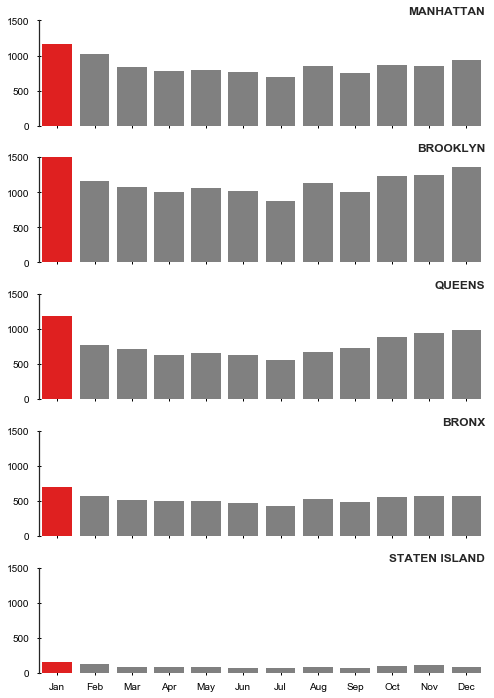

In [14]:
sns.set(style="white")

# Set up the matplotlib figure
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(8, 12), sharex=True, sharey=True)
f.subplots_adjust(hspace=.3)

for boro, ax in zip(borough_injuries_month, [ax1, ax2, ax3, ax4, ax5]):
    values = borough_injuries_month[boro].values
    colors = ['gray' if (x < max(values)) else 'red' for x in values]
    sns.barplot(months_abbr, borough_injuries_month[boro], palette=colors, ax=ax)
    ax.set_title(boro, loc='right', weight='bold', fontdict={'fontsize': 12})
    ax.set_ylabel('')
    ax.tick_params(direction='inout', length=4, width=1, colors='black')
    sns.despine(bottom=True)

plt.ylim(0, 1500)
plt.show();

# borough_injuries_month

In [15]:
borough_injuries_month

BOROUGH,MANHATTAN,BROOKLYN,QUEENS,BRONX,STATEN ISLAND
January,1162,1677,1184,699,159
February,1020,1166,771,572,122
March,841,1073,718,511,83
April,777,1008,629,503,79
May,798,1064,660,494,85
June,762,1026,637,466,75
July,695,875,558,429,72
August,854,1134,672,524,76
September,753,1009,736,488,69
October,862,1227,894,563,96


# borough_injuries_daily

In [16]:
borough_injuries_daily

BOROUGH,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
1,217,456,352,316,44
2,187,479,307,271,34
3,234,481,351,351,28
4,243,475,284,320,50
5,181,484,323,284,41
6,211,490,351,333,42
7,213,431,329,346,30
8,194,454,333,305,33
9,176,438,299,274,30
10,182,486,383,298,46


# SAVE

## DATA TO CSV

In [18]:
# CSV verison
data.to_csv("../data/injuries_2013_present.csv")

## DATA TO JSON

In [19]:
def serise_to_json(data):
    dates = np.array(data.index.values, dtype=np.datetime64)
    values = data.values
    dates_str = [str(i)[:10] for i in dates]
    return [{'date': d, 'value': int(v)} for d, v in zip(dates_str, values)]

### Monthly 

In [20]:
monthly_json = serise_to_json(monthly_injured)
monthly_json[:5]

[{'date': '2013-01-31', 'value': 1113},
 {'date': '2013-02-28', 'value': 984},
 {'date': '2013-03-31', 'value': 987},
 {'date': '2013-04-30', 'value': 901},
 {'date': '2013-05-31', 'value': 982}]

In [21]:
monthly_outname = '../data/monthly_injured_2013_present.json'
with open(monthly_outname, 'w') as outfile:
    json.dump(monthly_json, outfile)

### Daily

In [22]:
daily_json = serise_to_json(daily_injured)

In [23]:
daily_outname = '../data/daily_injured_2013_present.json'
with open(daily_outname, 'w') as outfile:
    json.dump(daily_json, outfile)

In [24]:
# MOST DANGEROUS DAY
# 2017-01-23 - 228 PEDESTRIANS INJURIES
pd.DataFrame(daily_json).sort_values(by='value', ascending=False)[:10]

,date,value
1483,2017-01-23,228
1484,2017-01-24,133
1477,2017-01-17,105
329,2013-11-26,103
1052,2015-11-19,103
1395,2016-10-27,101
1463,2017-01-03,98
339,2013-12-06,90
1428,2016-11-29,89
694,2014-11-26,86
